## Workflow to analyze Photometry data

### Imports

In [1]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

### Variables

In [2]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

# if working from the main notebook repo
basefolder, _ = os.path.split(os.getcwd())
# if working from the noncanonical notebook repo (comment if not the case)
basefolder, _ = os.path.split(basefolder)

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'
basefolder

'c:\\Users\\phar0732\\Documents\\GitHub\\trialexp'

### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

### Reload a pre-existing dataset

In [3]:
# dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\photo_reaching_go_nogo_mf3_lp45_bar_off.pkl'
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\photo_reaching_go_nogo_mf3_lp100_cs_onset.pkl'

cont_dataset = load_dataset(dataset_full_path)
cont_dataset.cond_aliases

['Go hit', 'Go miss', 'Go hit error', 'NoGo hit', 'NoGo miss']

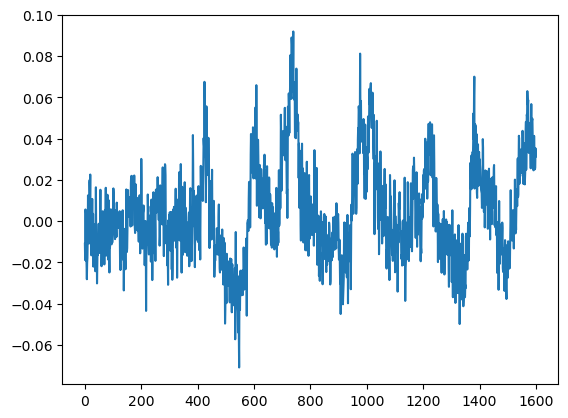

In [10]:
plt.plot(data_emd)

<AxesSubplot: xlabel='Time (samples)'>

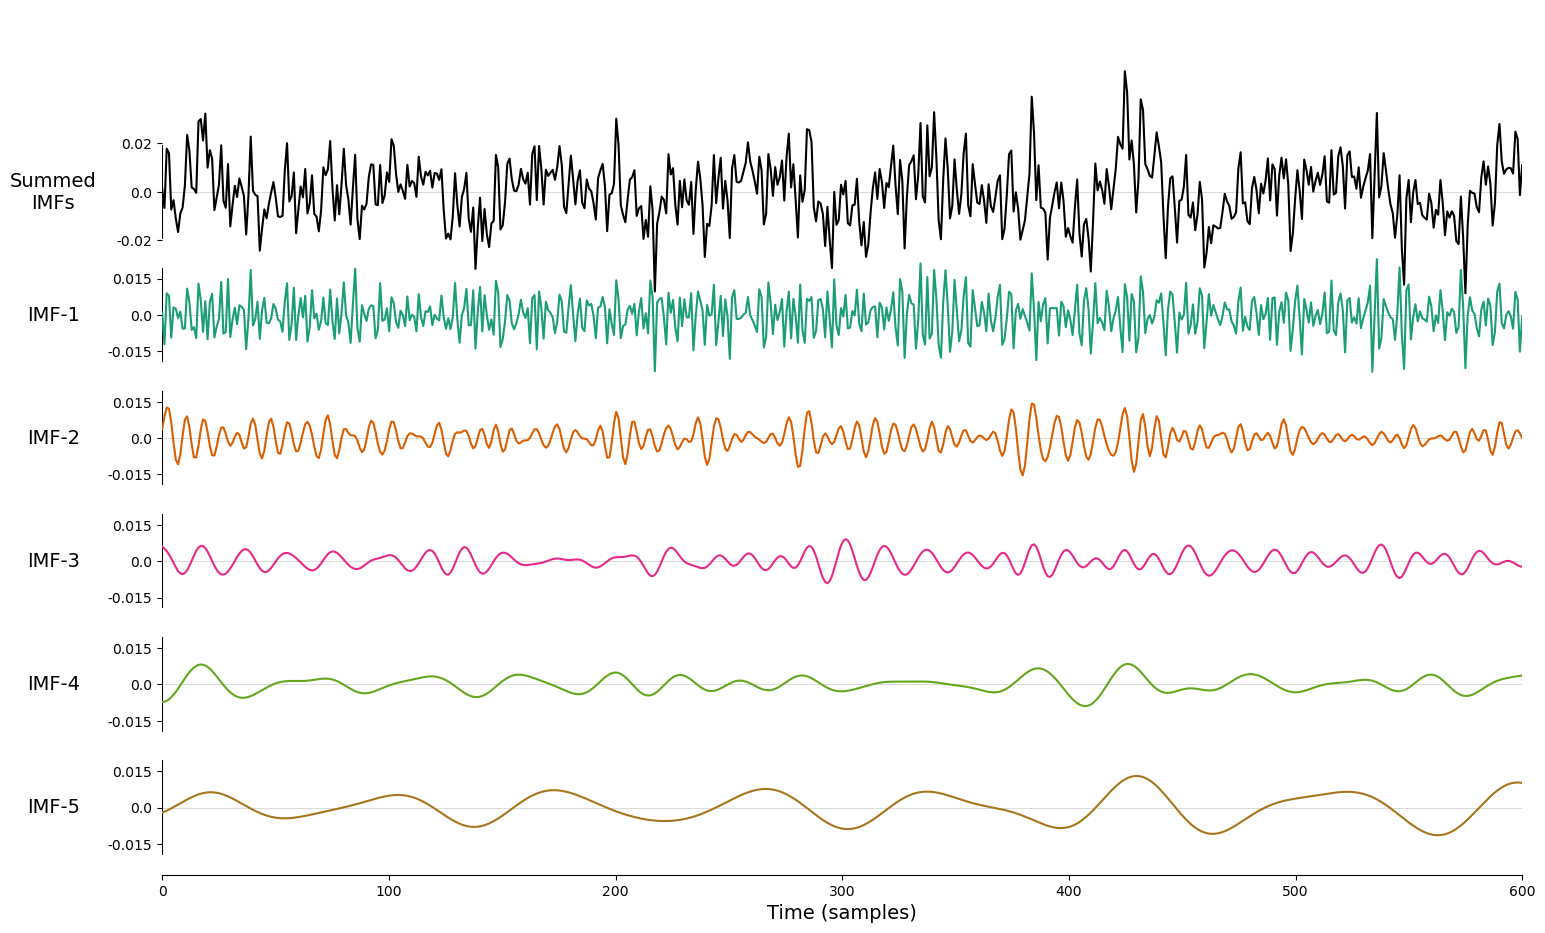

In [9]:
import emd
sample_rate = 200

trial_idx_cond = cont_dataset.metadata_df[cont_dataset.metadata_df.condition_ID == 0].index

var_name = 'analog_1_df_over_f'
chan_idx = cont_dataset.colnames_dict[var_name]

data_emd = cont_dataset.data[trial_idx_cond[2],chan_idx,:]



# Run a mask sift
imf = emd.sift.mask_sift(data_emd, max_imfs=5)

emd.plotting.plot_imfs(imf[:sample_rate*3, :])

In [106]:
trial_idx_cond = cont_dataset.metadata_df[cont_dataset.metadata_df.condition_ID == 0].index
trial_idx_cond

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8832, 8833, 8834, 8835, 8836, 8837, 8838, 8839, 8840, 8841],
           dtype='int64', length=3976)

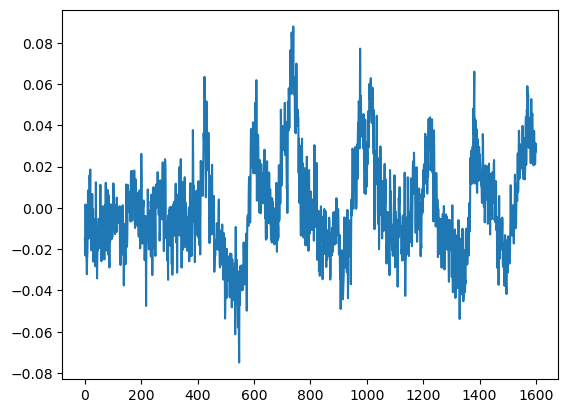

In [110]:

plt.show()

### Eliminate outliers from the dataset

### Optional methods

In [80]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filterout_conditions([])

# exclude some groups by IDs
cont_dataset.filterout_groups([])

# exclude some subjects
cont_dataset.filterout_subjects([0,1, 52])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
# cont_dataset.filter_min(min_trials = 7)

# Keep only last n sessions
cont_dataset.filter_lastNsessions(n = 3)

# Filter artifacted trials
# cont_dataset.filterout_clusters([-1, 1, 2]) # Good cluster is classically 0

# Exclude sessions by dates
# cont_dataset.filterout_dates(days_to_exclude = )

# To remove subjects who do not have
# trials in all the conditions
# Careful when using on sessions when not all conditions are present, 
# it could exclude a big number of whole sessions
# cont_dataset.filter_if_not_in_all_cond()


### Plot the photometry by condition

True    7168
Name: keep, dtype: int64

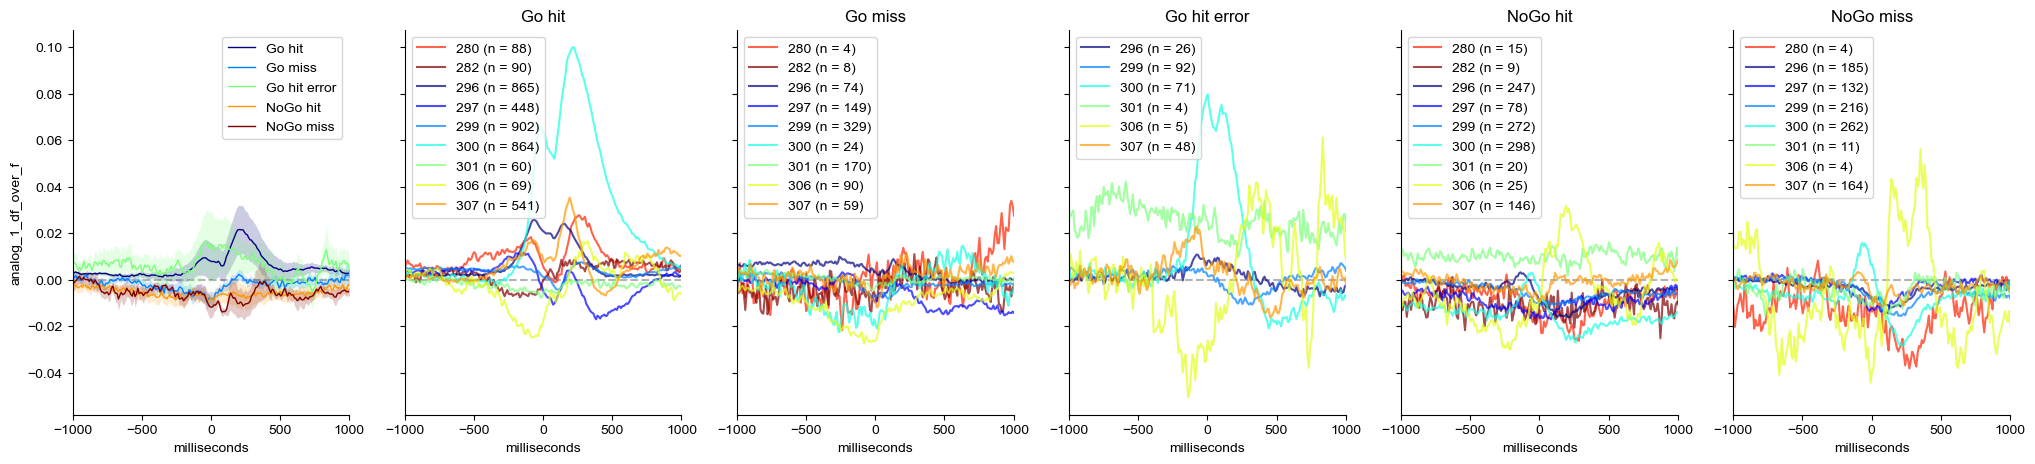

In [96]:
# if this was not set at creation
cont_dataset_copy.set_trial_window([-2, 6], 's')

cont_dataset_copy.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-1000, 1000],
    time_unit = 'milliseconds',
    ylim =  None,# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = True,
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    figsize = (25, 5),
    dpi = 100,
    verbose = False)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()



## Preparing data for model

In [133]:
X, y = cont_dataset_copy.export_to_sktime(
    folder = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs',
    name = 'reaching_go_nogo',
    vars_to_export = 'analog_1_df_over_f',
    verbose = True)

Nested Dataframe saved in C:\Users\phar0732\Documents\GitHub\trialexp\outputs\reaching_go_nogo.pkl
sktime-format data size: 85.80049133300781 Mb


In [9]:
X, y = load_sktime_dataset(r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\reaching_go_nogo.pkl')

In [25]:
dataset = load_dataset(
    r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\photo_reaching_go_nogo_mf3_lp45_bar_off_outliers_removed.pkl')

In [31]:
dataset.data.shape

(7020, 3, 800)

In [45]:
dataset.metadata_df.condition_ID.value_counts()

0    3885
3    1089
4     968
1     835
2     243
Name: condition_ID, dtype: int64

In [36]:
X,y = dataset.export_to_sktime(vars_to_export='analog_1_df_over_f')

In [37]:
X.shape

(7020, 800)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
from sktime.datatypes import get_examples
from sktime.datatypes import convert

convert(X, from_type="Panel", to_type="Series")
from sktime.datatypes import check_is_mtype

ValueError: Series is not a supported mtype

### Features Extraction

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sktime.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

tsfresh_trafo = TSFreshFeatureExtractor(default_fc_parameters="minimal")
randf = RandomForestClassifier(n_estimators=100)
pipe = make_pipeline(tsfresh_trafo, randf)

In [41]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)
accuracy_score(y_train, y_pred)

C:\Users\phar0732\AppData\Roaming\Python\Python38\site-packages\sktime\datatypes\_panel\_convert.py:712: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa
Feature Extraction: 100%|██████████| 5616/5616 [00:04<00:00, 1153.04it/s]
C:\Users\phar0732\AppData\Roaming\Python\Python38\site-packages\sktime\datatypes\_panel\_convert.py:712: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa
Feature Extraction: 100%|██████████| 5616/5616 [00:05<00:00, 1088.38it/s]


1.0

In [42]:
y_test_pred = pipe.predict(X_test)
accuracy_score(y_test, y_test_pred)

C:\Users\phar0732\AppData\Roaming\Python\Python38\site-packages\sktime\datatypes\_panel\_convert.py:712: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa
Feature Extraction: 100%|██████████| 1404/1404 [00:01<00:00, 1172.40it/s]


0.5548433048433048